In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

In [3]:
def gsw_pressure_arguments(coord_lats, depth_levels, y_transect):
    ''' The main purpose of this function is to reshape
    and tile the (m,) depth array and the (n,) coordinate
    slice so that they can both be (m,n) in order to find
    a (m,n) pressure field.
    '''
    depths = depth_levels.reshape(-1,1)
    depths_neg = depths * -1
    latitudes = coord_lats[y_transect,:]
    
    len_depths = len(depths)
    len_lats = len(latitudes)
    
    z = np.tile(depths_neg, (1, len_lats))
    lat = np.tile(latitudes, (len_depths, 1))
    return z, lat

def gsw_pressure_arguments_x(coord_lats, depth_levels, x_transect):
    depths = depth_levels.reshape(-1,1)
    depths_neg = depths * -1
    longitudes = coord_lats[:, x_transect]
    
    len_depths = len(depths)
    len_lons = len(longitudes)
    
    z = np.tile(depths_neg, (1, len_lons))
    lon = np.tile(longitudes, (len_depths, 1))
    return z, lon

# ------------------------------------------------------------------------------------------

def gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, salx, temx, tmask):
    ''' This function uses the z and lat calculated in the previous function to calculated
    pressure. This pressure is used alongside salinity and temperature to calculate
    density profiles. Even thought SA and CT are masked arrays (and pressure is not), the
    array for rho is unmasked. tmask is used to mask it, and this follows the same procedure
    as the orginal masking done for SA and CT.
    '''
    z, lat = gsw_pressure_arguments(coord_lats, depth_levels, y_transect)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

    SA = salx[time_ind, :, y_transect, :]
    CT = temx[time_ind, :, y_transect, :]

    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    tmask_rho = tmask[time_ind, : ,y_transect, :]   
    rho_masked = np.ma.array(rho, mask=tmask_rho)
        
    return rho_masked

def gsw_calculate_density_x(coord_lats, depth_levels, x_transect, time_ind, salx, temx, tmask):

    z, lon = gsw_pressure_arguments_x(coord_lats, depth_levels, x_transect)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,lon], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

    SA = salx[time_ind, :, :, x_transect]
    CT = temx[time_ind, :, :, x_transect]

    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    tmask_rho = tmask[time_ind, : ,:, x_transect]   
    rho_masked = np.ma.array(rho, mask=tmask_rho)
        
    return rho_masked

# ------------------------------------------------------------------------------------------

def plot_isopycnal_stories(sal, tem, tmask, y_transects, time_inds, coord_lats, depth_levels):
    '''This function plots vertical density profiles at different times (rows) for
    the idealized and realistic canyons (columns). It takes in the y index that 
    outlines the vertical slice. It also takes in the latitudes and depth necessary
    to calculate the pressure calculated inside the density function.
    '''
    x_inds = np.arange(sal.shape[3])
    fig, ax = plt.subplots(len(time_inds), len(y_transects), figsize=(18, len(time_inds)*5))
    cmap = cm.Spectral
    levels = np.linspace(1024, 1026, 8)
    for y_transect, n in zip(y_transects, np.arange(len(y_transects))):
        for time_ind, i in zip(time_inds, np.arange(len(time_inds))):
            rho = gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, sal, tem, tmask)
            p = ax[i,n].pcolormesh(x_inds, depth_levels, rho, cmap = cmap, vmin=1023.5, vmax=1026.5)
            c = ax[i,n].contour(x_inds, depth_levels, rho, levels = levels, colors='k', linewidths=1.2)
            ax[i,n].set_ylim([100,40])
            ax[i,n].set_xlim([0,sal.shape[3]])
            ax[i,n].set_title('hour: '+str(time_ind)+' and y = '+str(y_transect), fontsize=12)
            fig.colorbar(p, ax=ax[i,n])
            ax[i,n].set_axis_bgcolor('wheat')
    return fig

def plot_isopycnal_stories_x(sal, tem, tmask, x_transects, time_inds, coord_lats, depth_levels):
    y_inds = np.arange(sal.shape[2])
    fig, ax = plt.subplots(len(time_inds), len(x_transects), figsize=(18, len(time_inds)*5))
    cmap = cm.Spectral
    levels = np.linspace(1023.8, 1026, 8)
    for x_transect, n in zip(x_transects, np.arange(len(x_transects))):
        for time_ind, i in zip(time_inds, np.arange(len(time_inds))):
            rho = gsw_calculate_density_x(coord_lats, depth_levels, x_transect, time_ind, sal, tem, tmask)
            p = ax[i,n].pcolormesh(y_inds, depth_levels, rho, cmap = cmap, vmin=1023.5, vmax=1026.5)
            c = ax[i,n].contour(y_inds, depth_levels, rho, levels = levels, colors='k', linewidths=1.2)
            ax[i,n].set_ylim([100,40])
            ax[i,n].set_xlim([0,sal.shape[2]])
            ax[i,n].set_title('hour: '+str(time_ind)+' and y = '+str(x_transect), fontsize=12)
            fig.colorbar(p, ax=ax[i,n])
            ax[i,n].set_axis_bgcolor('wheat')
    return fig

In [4]:
depth_levels

array([    4.9752655 ,    15.09642696,    25.53630829,    36.45035934,
          48.0688858 ,    60.73197556,    74.9393158 ,    91.41963196,
         111.22411346,   135.84466553,   167.3487854 ,   208.50358582,
         262.82952881,   334.48800659,   427.8961792 ,   547.02954102,
         694.5501709 ,   871.09747314,  1075.10339355,  1303.23583984,
        1551.22729492,  1814.70251465,  2089.74609375,  2373.15991211,
        2662.48999023,  2955.93261719,  3252.20141602,  3550.39672852,
        3849.89794922,  4150.28125   ], dtype=float32)

# Along Latitude: Day 18

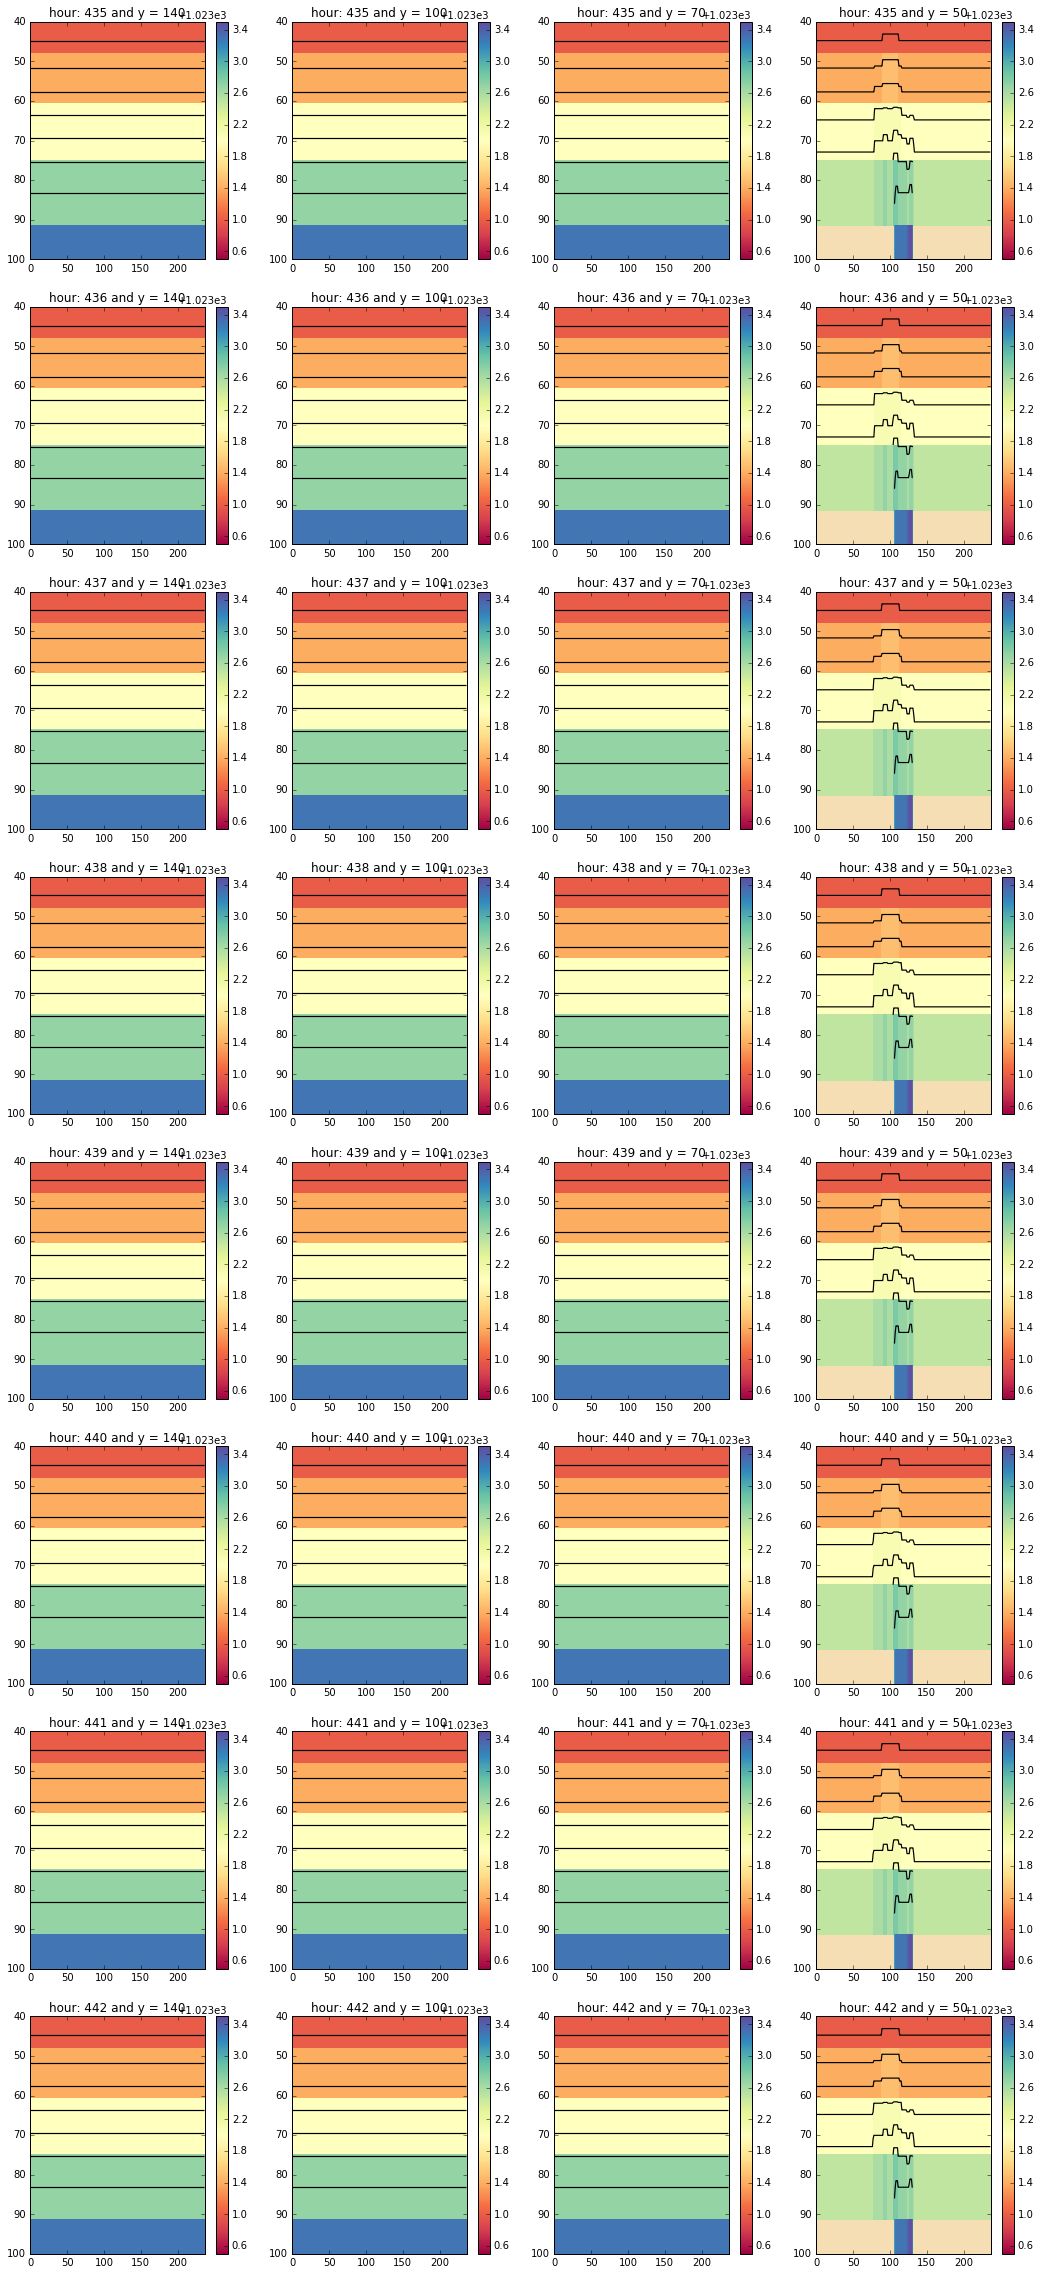

In [5]:
t1, t2 = 435, 447
y_transects = [140, 100, 70, 50]
time_inds = np.arange(t1, t1+8)

fig = plot_isopycnal_stories(sal, tem, tmask, y_transects, time_inds, coord_lats, depth_levels)

# Along Latitude: Day 8

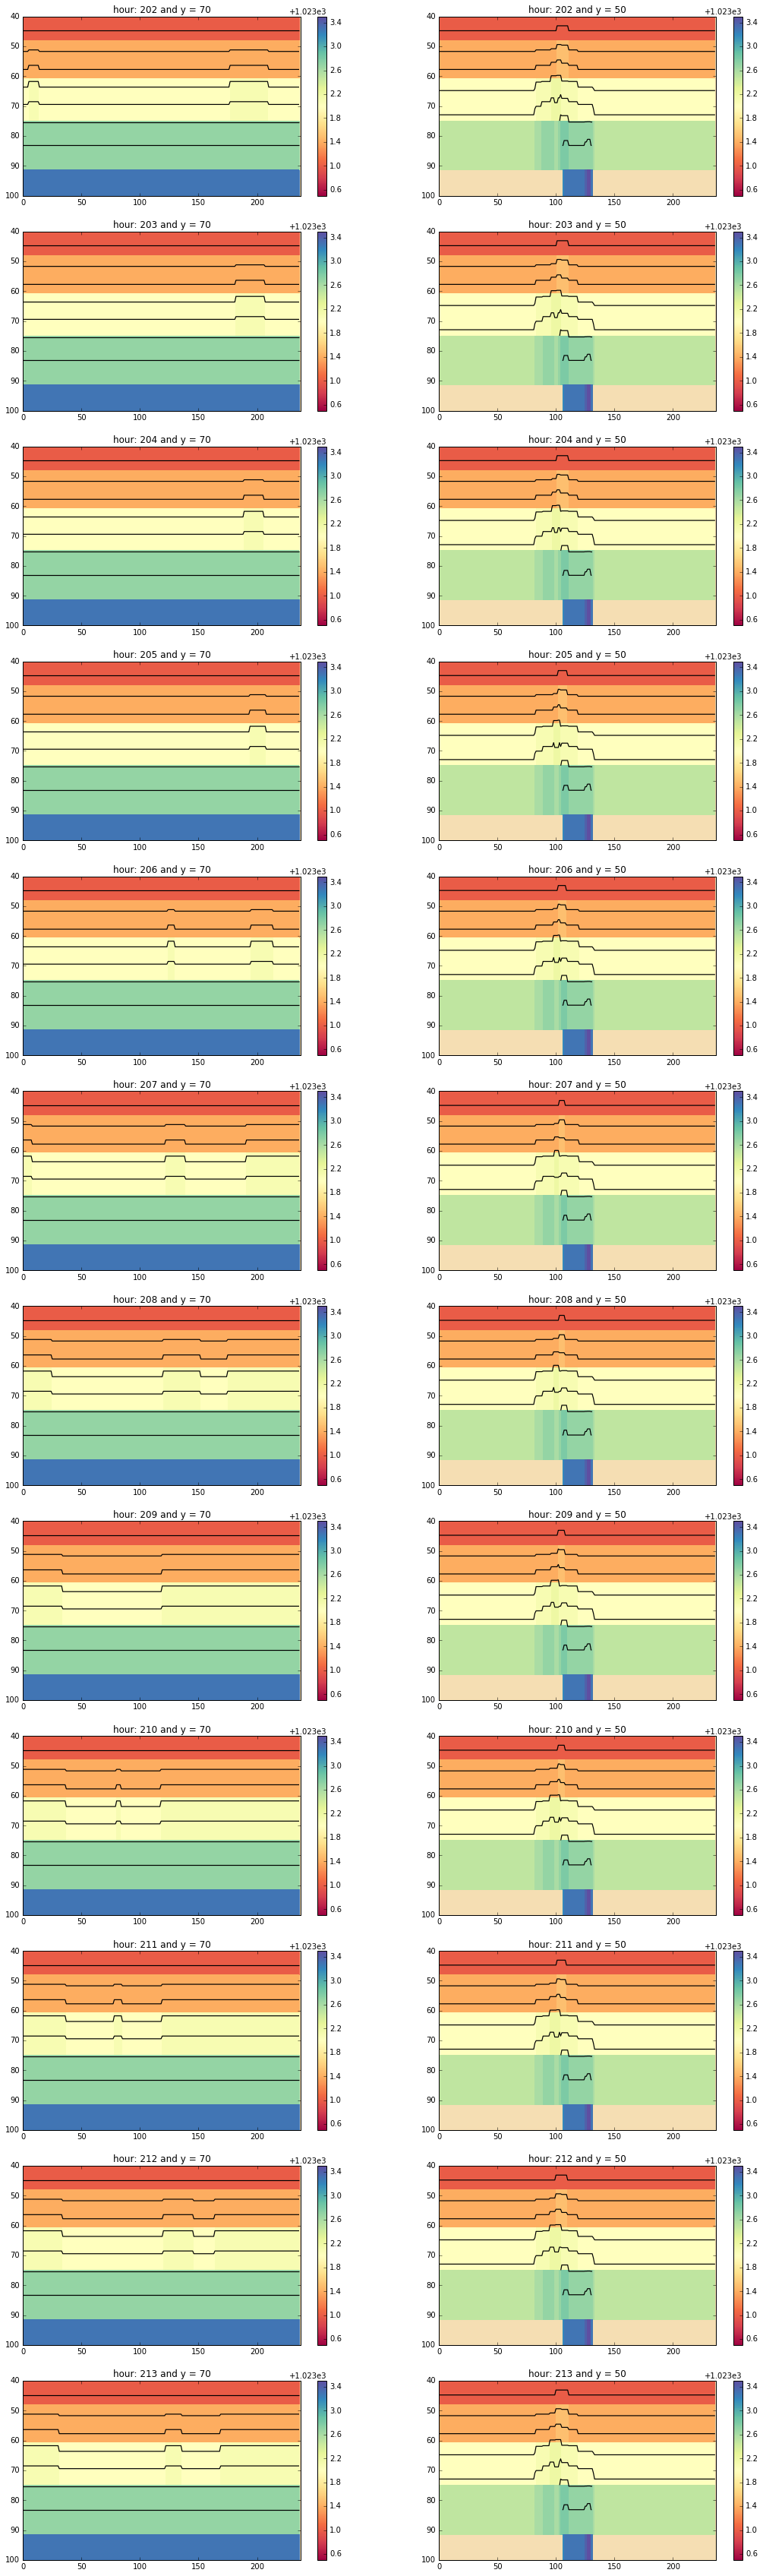

In [170]:
y_transects = [70, 50]
time_inds = np.arange(202, 202+12)
depth_levels = depth_levels
fig = plot_isopycnal_stories(sal, tem, tmask, y_transects, time_inds, coord_lats, depth_levels)

# Along Latitude: Day 3

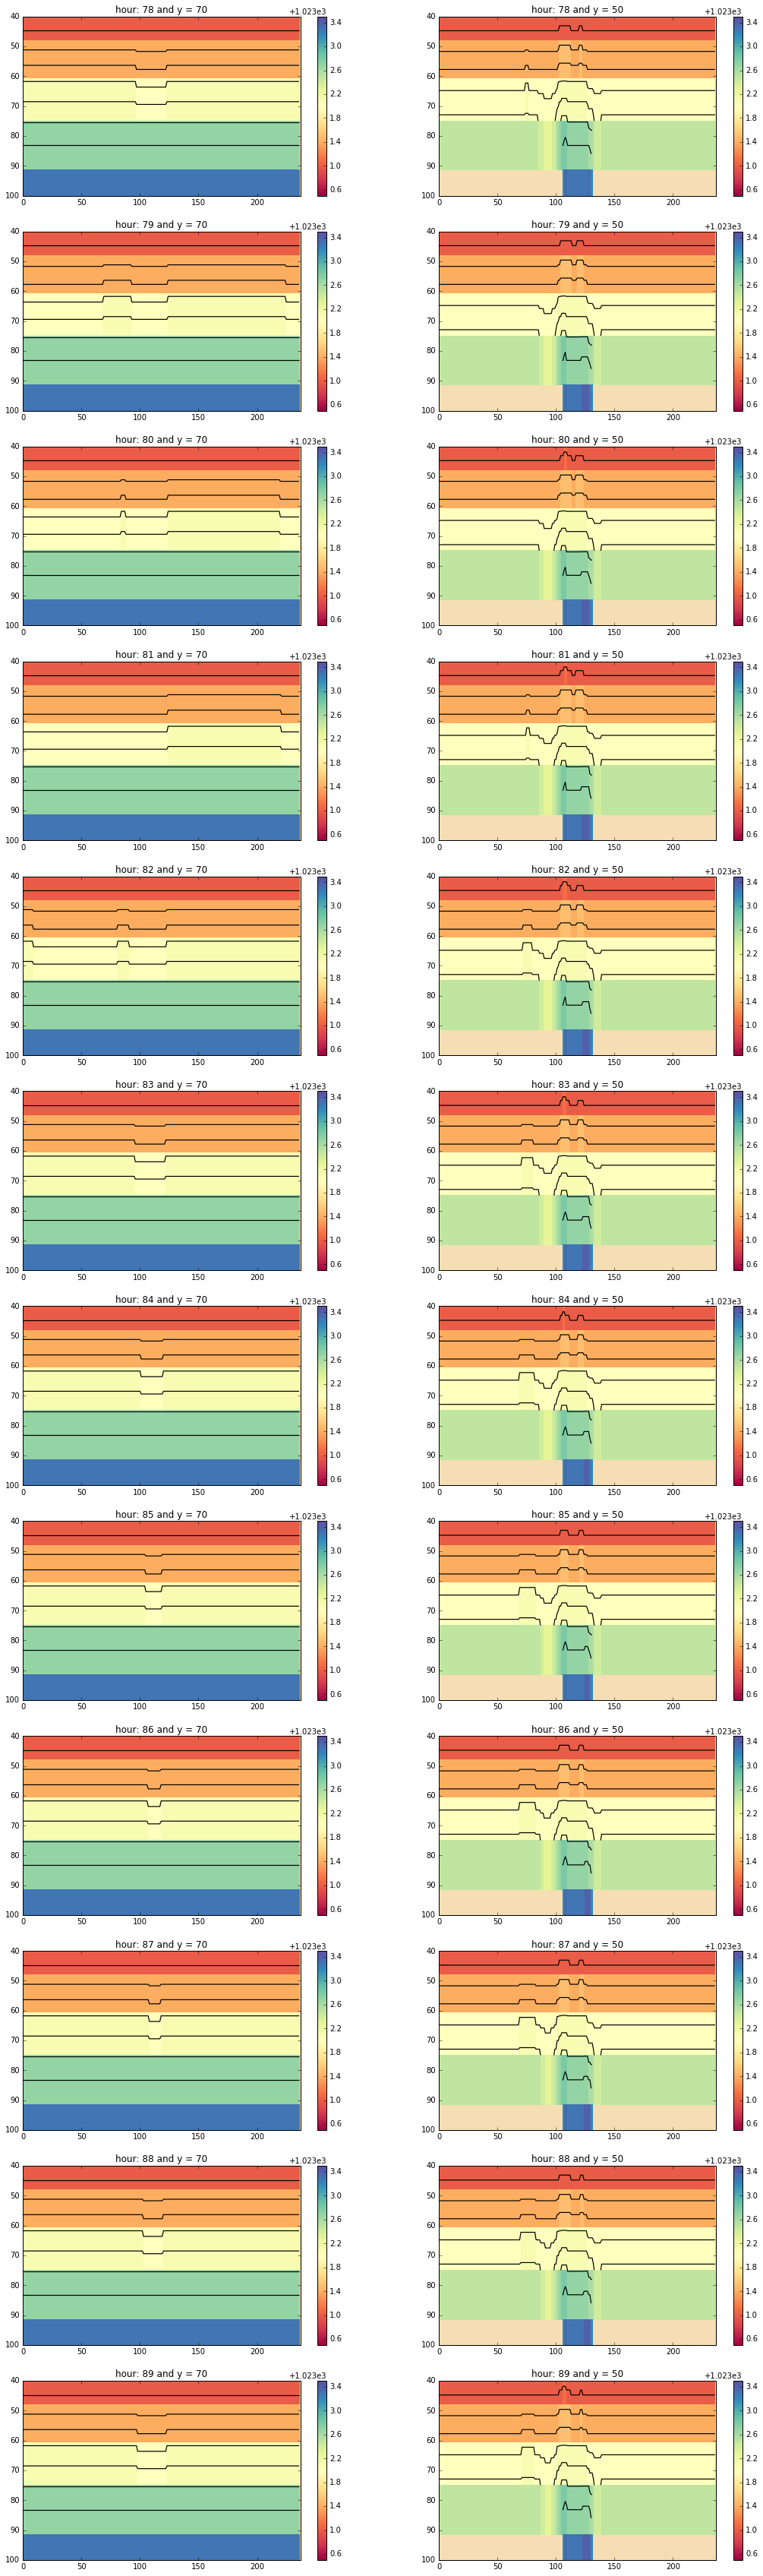

In [171]:
y_transects = [70, 50]
time_inds = np.arange(78, 78+12)
depth_levels = depth_levels
fig = plot_isopycnal_stories(sal, tem, tmask, y_transects, time_inds, coord_lats, depth_levels)

# Along Longitude: Day 18

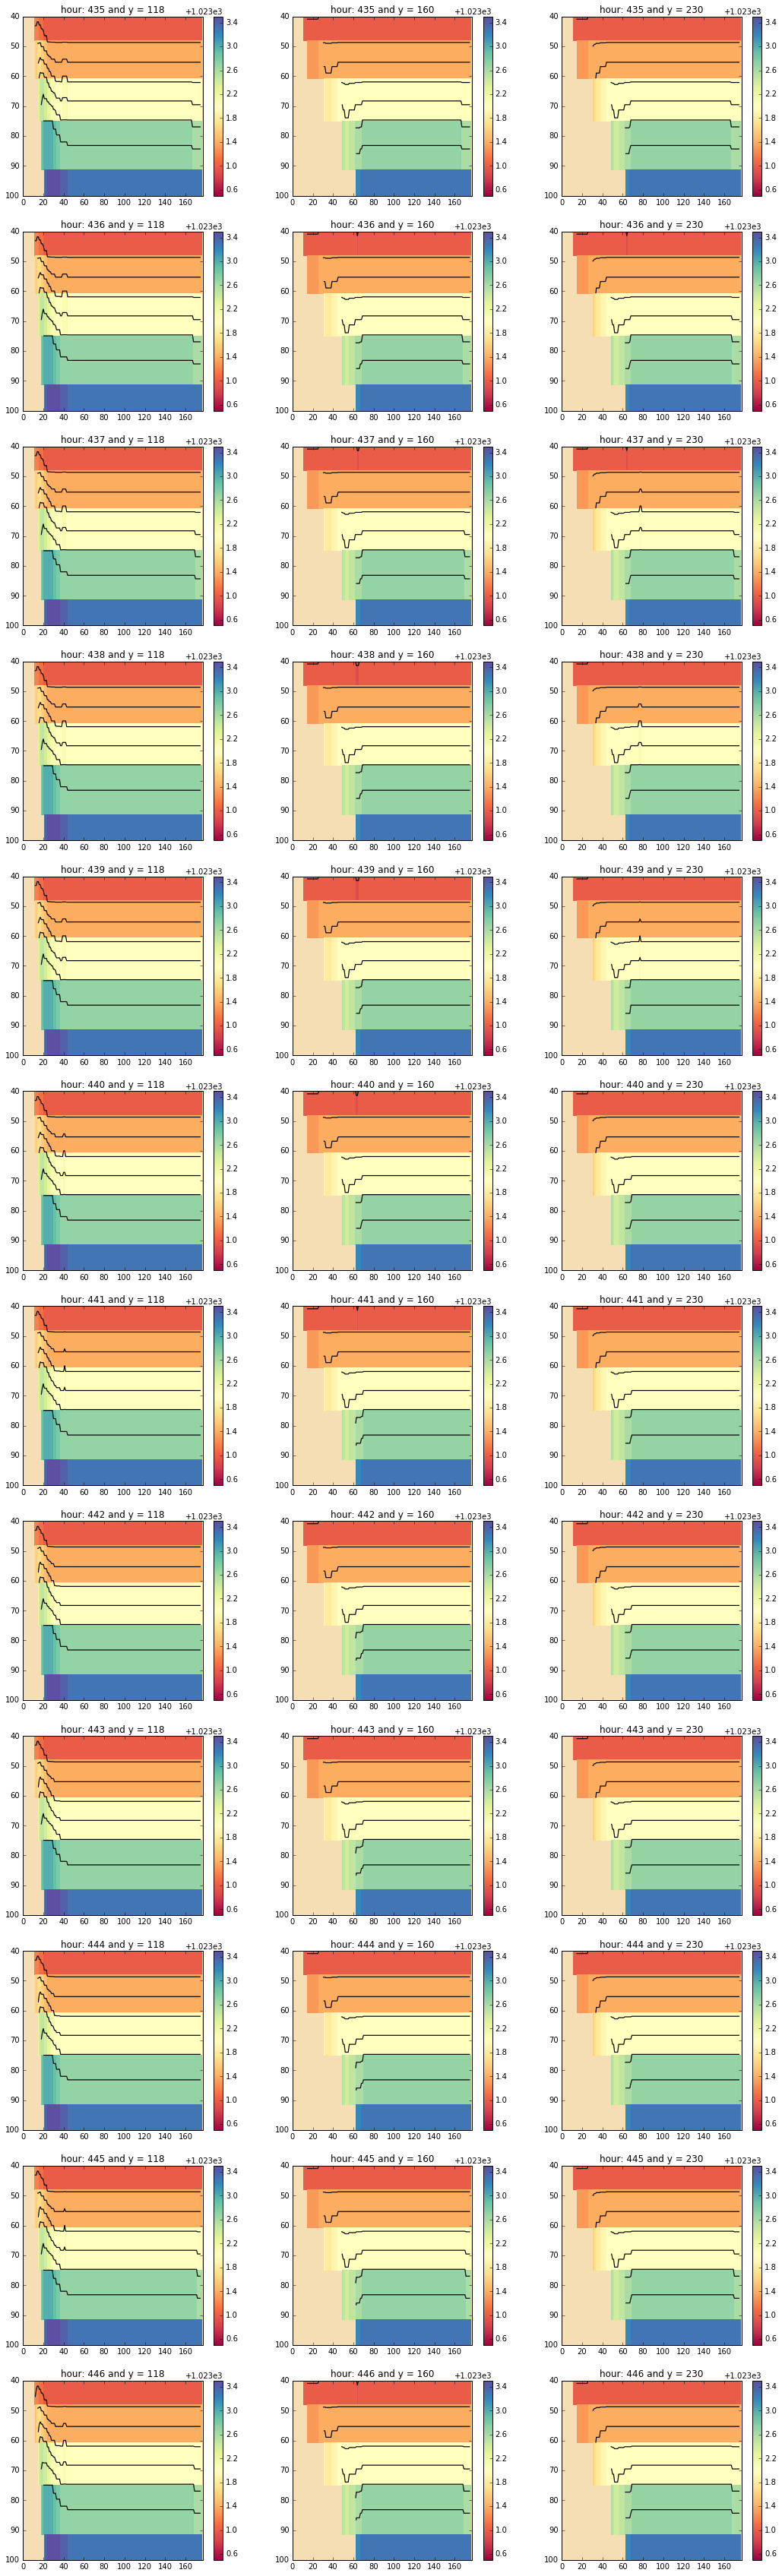

In [198]:
x_transects = [118, 160, 230]
time_inds = np.arange(t1, t1+12)
depth_levels = depth_levels
fig = plot_isopycnal_stories_x(sal, tem, tmask, x_transects, time_inds, coord_lats, depth_levels)

# Along Longitude: Day 8

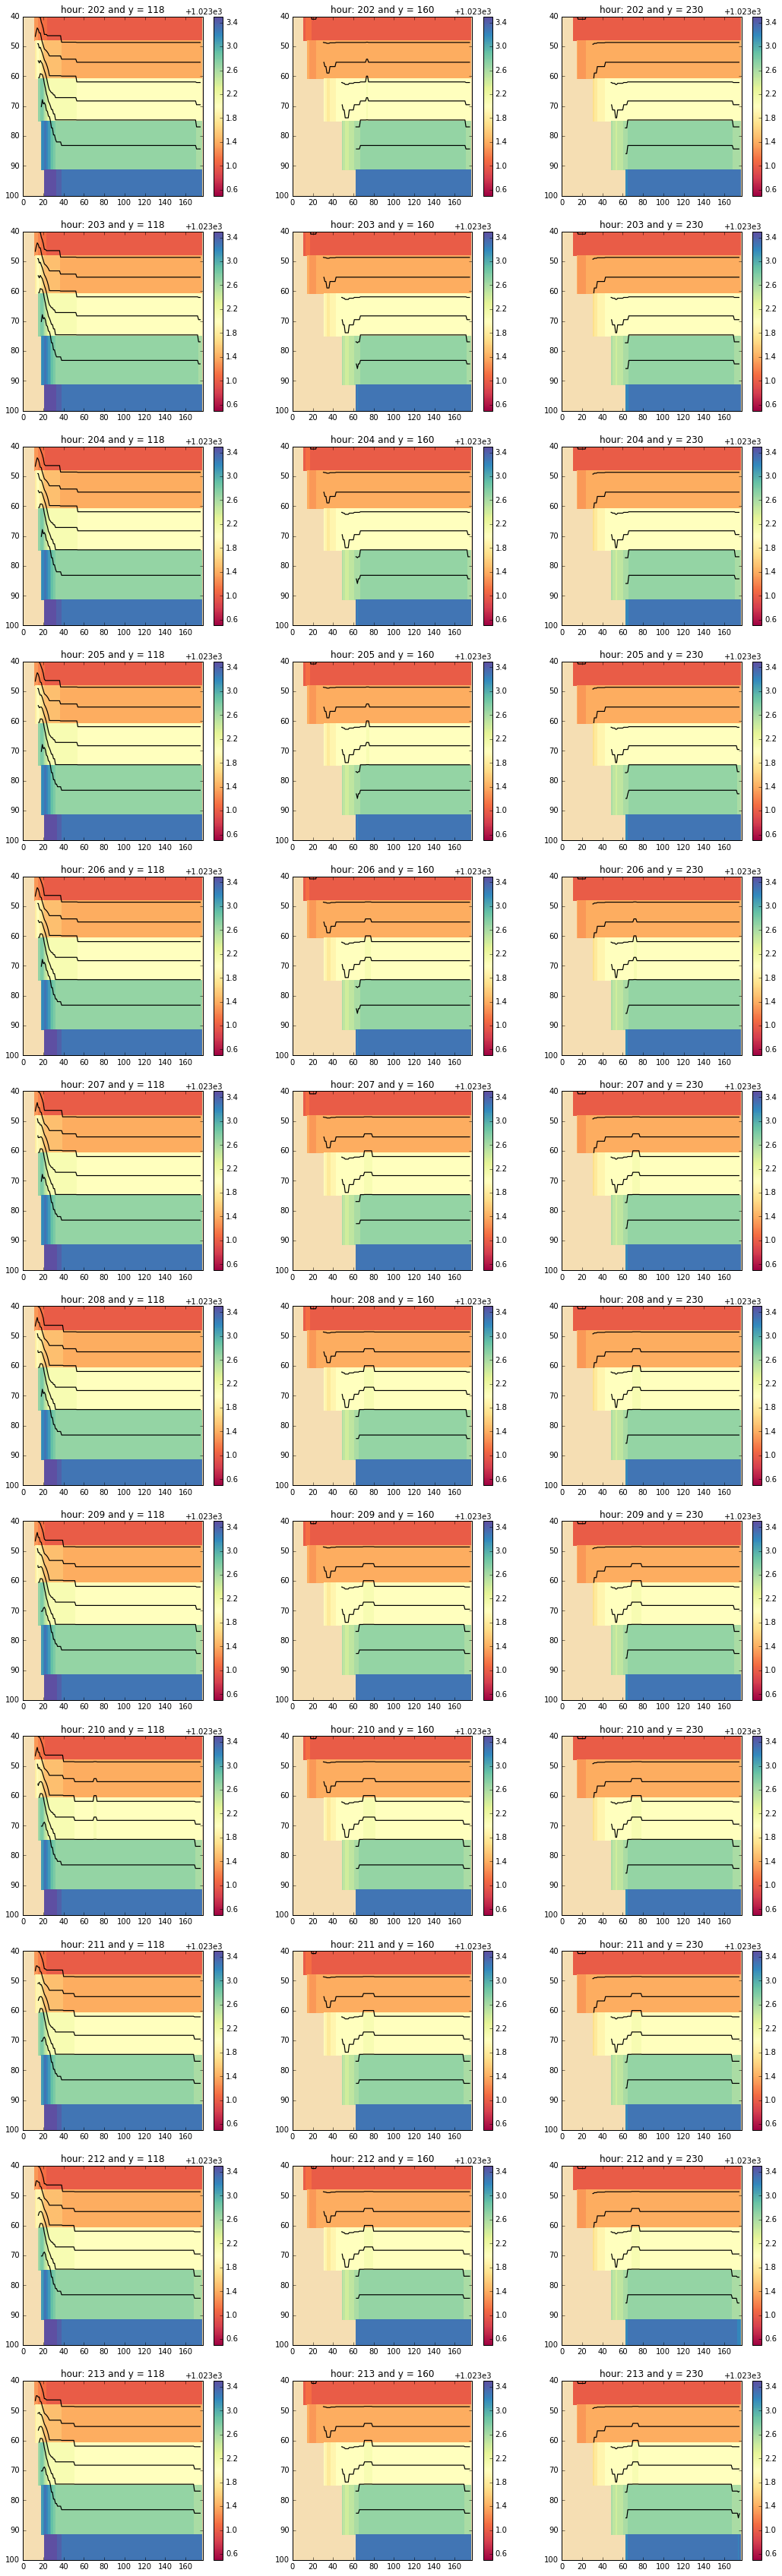

In [197]:
x_transects = [118, 160, 230]
time_inds = np.arange(202, 202+12)
depth_levels = depth_levels
fig = plot_isopycnal_stories_x(sal, tem, tmask, x_transects, time_inds, coord_lats, depth_levels)